## Thermal subduction, linear rheology:


The viscous rheology in this model is similar to the models described in the PhD thesis of Micheal Kaplan



**Keywords:** subduction, thermally-activated creep, 


**References:**


Kaplan, Michael. Numerical Geodynamics of Solid Planetary Deformation. Diss. University of Southern California, 2015.

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function
from unsupported.interfaces import markerLine2D

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

/root/underworld2/unsupported/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


Model name and directories
-----

In [2]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [3]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [4]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/checkpoint/ is empty


In [5]:
# setup summary output file (name above)
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[-1]  #This corresponds to the column you write time data to
    else:
        realtime = prevdata[prevdata.shape[0]-1, -1]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [6]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormat

<Quantity(10000.0, 'meter / megayear')>

In [7]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Set parameter dictionaries**

* Parameters are stored in dictionaries. 
* If starting from checkpoint, parameters are loaded using pickle
* If params are passed in as flags to the script, they overwrite 


In [8]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies



In [9]:
dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']

def save_pickles(dict_list, dict_names, dictPath):
    import pickle
    counter = 0
    for pdict in dict_list:
        myfile = os.path.join(dictPath, dict_names[counter])
        with open(myfile, 'wb') as f:
            pickle.dump(pdict, f)
        counter+=1


#ended up having to pretty much write a hard-coded function
#All dictionaries we want checkpointed will have to  be added here 
#and where the function is called
#Fortunately, this function is only called ONCE

def load_pickles():
    import pickle
    dirpath = os.path.join(checkpointPath, str(step))
    dpfile = open(os.path.join(dirpath, 'dp.pkl'), 'r')
    dp = pickle.load(dpfile)
#    #
    ndpfile = open(os.path.join(dirpath, 'ndp.pkl'), 'r')
    ndp = edict(pickle.load(ndpfile))
    #
    sffile = open(os.path.join(dirpath, 'sf.pkl'), 'r')
    sf = edict(pickle.load(sffile))
    #
    mdfile = open(os.path.join(dirpath, 'md.pkl'), 'r')
    md = edict(pickle.load(mdfile))
    return dp, ndp, sf, md

In [10]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


dp = edict({'LS':670*1e3, #Scaling Length scale
            'depth':670*1e3, #Depth of domain
            'rho':3300.,  #reference density
            'g':9.8, #surface gravity
            'eta0':1e20, #reference viscosity
            'k':1e-6, #thermal diffusivity
            'a':3e-5, #surface thermal expansivity
            'R':8.314, #gas constant
            'TP':1673., #mantle potential temp (K)
            'TS':273., #surface temp (K)
            #Rheology - flow law paramters
            'Adf':3e-11, #pre-exp factor for diffusion creep
            'Edf':1e5, #Total viscosity variation in the Kaplan model
            'cm':40e6, #mantle cohesion in Byerlee law
            'cc':40e6, #mantle cohesion in Byerlee law
            'ci':40e6, #mantle cohesion in Byerlee law
            'cf':40e6, #mantle cohesion in Byerlee law
            'fcm':0.03,   #mantle friction coefficient in Byerlee law (tan(phi))
            'fcc':0.03,   #crust friction coefficient 
            'fci':0.03,   #subduction interface friction coefficient
            'fcf':0.03,   #subduction interface friction coefficient
            #Rheology - cutoff values
            'eta_min':1e17, 
            'eta_max':1e25, #viscosity max in the mantle material
            'eta_min_crust':1e20, #viscosity min in the weak-crust material
            'eta_max_crust':1e20, #viscosity max in the weak-crust material
            'eta_min_interface':1e20, #viscosity min in the subduction interface material
            'eta_max_interface':1e20, #viscosity max in the subduction interface material
            'eta_min_fault':1e20, #viscosity min in the subduction interface material
            'eta_max_fault':1e20, #viscosity max in the subduction interface material
            #Length scales
            'MANTLETOCRUST':10.*1e3, #Crust depth
            'HARZBURGDEPTH':40e3,
            'CRUSTTOMANTLE':800.*1e3,
            'LITHTOMANTLE':(900.*1e3),
            'MANTLETOLITH':200.*1e3, 
            'TOPOHEIGHT':10.*1e3,  #rock-air topography limits
            'CRUSTTOECL':100.*1e3,
            'LOWMANTLEDEPTH':660.*1e3, 
            'CRUSTVISCUTOFF':150.*1e3, #Deeper than this, crust material rheology reverts to mantle rheology
            'AGETRACKDEPTH':100e3, #above this depth we track the age of the lithsphere (below age is assumed zero)
            #Slab and plate parameters
            'roc':250e3,     #radius of curvature of slab
            'subzone':0.0,   #X position of subduction zone...km
            'lRidge':-0.5*(670e3*4),  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
            'rRidge':0.5*(670e3*4),
            'maxDepth':250e3,
            'theta':70., #Angle to truncate the slab (can also control with a maxDepth param)
            'slabmaxAge':60e6, #age of subduction plate at trench
            'platemaxAge':60e6, #max age of slab (Plate model)
            'sense':'Right', #dip direction
            'op_age_fac':0.5, #this controls the overidding plate age reduction
            #Misc
            'StALS':100e3, #depth of sticky air layer
            'Steta_n':1e19, #stick air viscosity, normal
            'Steta_s':1e18, #stick air viscosity, shear 
            'plate_vel':4,
            'low_mantle_visc_fac':30.
           })

#append any derived parameters to the dictionary
dp.deltaT = dp.TP - dp.TS




In [11]:
#Modelling and Physics switches

md = edict({'refineMesh':False,
            'stickyAir':False,
            'subductionFault':True,
            'symmetricIcs':False,
            'velBcs':False,
            'aspectRatio':4,
            'compBuoyancy':False, #use compositional & phase buoyancy, or simply thermal
            'periodicBcs':False,
            'RES':64
            })

In [12]:
###########
#If starting from a checkpoint load params from file
###########

if checkpointLoad:
    dp, ndp, sf, md = load_pickles()  #remember to add any extra dictionaries


In [13]:
###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
        
        try:
            val = float(val) #try to convert everything to a float, else remains string
        except ValueError:
            pass
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [14]:
#Only build these guys first time around, otherwise the read from checkpoints
#Important because some of these params (like SZ location) may change during model evolution


if not checkpointLoad:

    
    
    sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
                'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) , 
                'vel':dp.LS/dp.k,
                'SR':dp.LS**2/dp.k    
               })

    #dimensionless parameters

    ndp = edict({'RA':(dp.g*dp.rho*dp.a*(dp.TP - dp.TS)*(dp.LS)**3)/(dp.k*dp.eta0),
                 'Edf':math.log(dp.Edf),
                 'TSP':0., 
                 'TBP':1.,
                 'TPP':(dp.TP - dp.TS)/dp.deltaT, #dimensionless potential temp
                 'TS':dp.TS/dp.deltaT,
                 'TP':dp.TP/dp.deltaT,
                 'cm':dp.cm*sf.stress,
                 'cc':dp.cc*sf.stress,    #{dimensionless cohesion in mantle, crust, interface}
                 'ci':dp.ci*sf.stress,
                 'cf':dp.cf*sf.stress,
                 'fcmd':dp.fcm*sf.lith_grad, 
                 'fccd':dp.fcc*sf.lith_grad, #{dimensionless friction coefficient in mantle, crust, interface}
                 'fcid':dp.fci*sf.lith_grad, 
                 'fcfd':dp.fci*sf.lith_grad, 
                 #Rheology - cutoff values
                 'eta_min':dp.eta_min/dp.eta0, 
                 'eta_max':dp.eta_max/dp.eta0, #viscosity max in the mantle material
                 'eta_min_crust':dp.eta_min_crust/dp.eta0, #viscosity min in the weak-crust material
                 'eta_max_crust':dp.eta_max_crust/dp.eta0, #viscosity max in the weak-crust material
                 'eta_min_interface':dp.eta_min_interface/dp.eta0, #viscosity min in the subduction interface material
                 'eta_max_interface':dp.eta_max_interface/dp.eta0, #viscosity max in the subduction interface material
                 'eta_min_fault':dp.eta_min_fault/dp.eta0, #viscosity min in the subduction interface material
                 'eta_max_fault':dp.eta_max_fault/dp.eta0, #viscosity max in the subduction interface material   
                 #Length scales
                 'MANTLETOCRUST':dp.MANTLETOCRUST/dp.LS, #Crust depth
                 'HARZBURGDEPTH':dp.HARZBURGDEPTH/dp.LS,
                 'CRUSTTOMANTLE':dp.CRUSTTOMANTLE/dp.LS,
                 'LITHTOMANTLE':dp.LITHTOMANTLE/dp.LS,
                 'MANTLETOLITH':dp.MANTLETOLITH/dp.LS,
                 'TOPOHEIGHT':dp.TOPOHEIGHT/dp.LS,  #rock-air topography limits
                 'CRUSTTOECL':dp.CRUSTTOECL/dp.LS,
                 'LOWMANTLEDEPTH':dp.LOWMANTLEDEPTH/dp.LS, 
                 'CRUSTVISCUTOFF':dp.CRUSTVISCUTOFF/dp.LS, #Deeper than this, crust material rheology reverts to mantle rheology
                 'AGETRACKDEPTH':dp.AGETRACKDEPTH/dp.LS,
                 #Slab and plate parameters
                 'roc':dp.roc/dp.LS,     #radius of curvature of slab
                 'subzone':dp.subzone/dp.LS,   #X position of subduction zone...km
                 'lRidge':dp.lRidge/dp.LS,  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
                 'rRidge':dp.rRidge/dp.LS,
                 'maxDepth':dp.maxDepth/dp.LS,    
                 #misc
                 'Steta_n':dp.Steta_n/dp.eta0, #stick air viscosity, normal
                 'Steta_s':dp.Steta_n/dp.eta0, #stick air viscosity, shear 
                 'StALS':dp.StALS/dp.LS,
                 'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
                 'low_mantle_visc_fac':dp.low_mantle_visc_fac
                })



    #Append any more derived paramters
    ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
    dp.CVR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.))
    ndp.CVR = dp.CVR*sf.vel #characteristic velocity

In [15]:
ndp.Edf

11.512925464970229

In [16]:
ndp.plate_vel, sf.vel, (cmpery.to(u.m/u.second)).magnitude

(849.2588923739356, 670000000000.0, 3.168876464081849e-10)

**Model setup parameters**

In [17]:
###########
#Model setup parameters
###########

#Domain and Mesh paramters
dim = 2          # number of spatial dimensions

tot_depth = np.round(dp.depth/dp.LS, 3)

#These options allow us to explore the choice of different length scalings

if tot_depth == 1.: #Depth equal to length scale
    MINY = 0.
    MAXY = 1.
elif tot_depth > 1.: #Depth larger than to length scale
    MINY = 0.
    MAXY = tot_depth
    
elif tot_depth < 1.: #Depth smaller to length scale
    MINY = np.round(1. - tot_depth, 2)
    MAXY = 1.
    
MINX = np.round(-1.*tot_depth*md.aspectRatio/2., 2)  #Aspect ratio is fixed, x-domain shifts according to system depth and length scale

MAXX = np.round(1.*tot_depth*md.aspectRatio/2., 2)

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    

Xres = int(md.RES*md.aspectRatio)
#if MINY == 0.5:
#    Xres = int(2.*RES*aspectRatio)
    

if md.stickyAir:
    Yres = md.RES
    MAXY = np.round(MAXY + dp.StALS/dp.LS, 2)
    
else:
    Yres = md.RES
    MAXY = np.round(MAXY, 2)

periodic = [False, False]
if md.periodicBcs:
    periodic = [True, False]
    
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff
PIC_integration=True
ppc = 25

#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 10, 10
gldbs_output = 2
checkpoint_every, files_output = 2, 100
metric_output = 1
sticky_air_temp = 1e6

Create mesh and finite element variables
------

In [18]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [19]:
mesh.reset()

In [20]:
###########
#Mesh refinement
###########

#X-Axis

if md.refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

In [21]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = MAXY #nodes will remain along this line


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [22]:
###########
#Mesh refinement
###########

if md.refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5001
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

In [23]:
#fig= glucifer.Figure()

#fig.append(glucifer.objects.Mesh(mesh))

#fig.show()
#fig.save_database('test.gldb')

In [24]:
#THis is a hack for adding a sticky air domain, we refine MAXY and things like the temperature stencil work from Y = 1. 

if md.stickyAir:
    MAXY = 1.

Initial conditions
-------


In [25]:
coordinate = fn.input()
depthFn = MAXY - coordinate[1] #a function providing the depth


xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]


In [26]:

def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX
    r_grad =  1./(abs(rMOR-sz))
    l_grad =  1./(abs(sz-lMOR))
    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, r_grad*opFac*(xFn -abs(rMOR)) / (abs(MAXX-rMOR))),
                                      (True, l_grad*fn.math.abs((((xFn + abs(lMOR)) / (abs(lMOR - MINX))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [27]:
###########
#Thermal initial condition - half-space coooling
###########


#  a few conversions
ageAtTrenchSeconds = min(dp.platemaxAge*(3600*24*365), dp.slabmaxAge*(3600*24*365))
#slab perturbation params (mostly dimensionless / model params here)
phi = 90. - dp.theta
Org = (ndp.subzone, MAXY-ndp.roc)

#First build the top TBL
ageFn = age_fn(xFn, sz =ndp.subzone, lMOR=ndp.lRidge,rMOR=ndp.rRidge, conjugate_plate=True, opFac = dp.op_age_fac)
#dimensionlize the age function
ageFn *= ageAtTrenchSeconds #seconds to year
w0 = (2.*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (ndp.TP - ndp.TS) *fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function
tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, ndp.TPP)])

if not md.symmetricIcs:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()



In [28]:
#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2



#We use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , ndp.roc)
Ic = inCircleFnGenerator(Org , ndp.roc - w0)
Cc = inCircleFnGenerator(Org , ndp.roc - (1.2*ndp.MANTLETOCRUST)) #... weak zone on 'outside' of slab
Hc = inCircleFnGenerator(Org , ndp.roc - ndp.HARZBURGDEPTH) #... Harzburgite layer 
dx = (ndp.roc)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if dp.sense == 'Left':
    ptx = ndp.subzone - dx
else:
    ptx = ndp.subzone + dx
coords = ((0.+ ndp.subzone, MAXY), (0.+ ndp.subzone, MAXY-ndp.roc), (ptx, MAXY))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation - could probably avoid particle walk here
if not md.symmetricIcs:
    if not checkpointLoad:
        sdFn = ((ndp.roc - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (MAXY - ndp.maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]


In [29]:
#sdFn = ((RocM - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
#slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
#sdFn, slabFn

In [30]:
#Make sure material in sticky air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= MAXY:
                temperatureField.data[index] = ndp.TSP

In [31]:
#fn.math.erf((sdFn*dp.LS)/(2.*fn.math.sqrt(dp.k*(slabmaxAge*(3600*24*365))))) 
#CRUSTVISCUTOFF, MANTLETOCRUST*3

def matplot_field(temperatureField, dp):
    if uw.nProcs() != 1:
        print("only in Serial folks")
    else:
        import matplotlib.pyplot as pyplt
        try :
            if(__IPYTHON__) :
                get_ipython().magic(u'matplotlib inline')
        except NameError :
            pass
        field_data = temperatureField.data.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
        fig, ax = pyplt.subplots(figsize=(32,2))
        ql = dp.LS/1e3
        pyplt.ioff()
        cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
        fig.colorbar(cax, orientation='horizontal' )
        #ax.set_x([0,dp.LS*aspectRatio])
        pyplt.tight_layout()
        
        return fig, ax
        
fig, ax = matplot_field(temperatureField, dp)
fig.savefig('test.png')       

In [32]:
temperatureField.data.min(), temperatureField.data.max()

(0.0, 1.0)

In [33]:

#ageFn = age_fn(xFn)

In [34]:

#fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Surface(mesh,temperatureField ))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.show()

##fig.save_database('test.gldb')
#fig.save_image('test.png')


Boundary conditions
-------

In [35]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]

VelBCs = mesh.specialSets["Empty"]



if md.velBcs:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (ndp.subzone - 0.05*aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (ndp.subzone + 0.05*aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if md.velBcs:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )






if periodic[0] == True:
    if md.velBcs:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [36]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Swarm setup
-----


In [37]:
###########
#Material Swarm and variables
###########

#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
#tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
ageVariable = gSwarm.add_variable( dataType="double", count=1 )
#testVariable = gSwarm.add_variable( dataType="float", count=1 )


#these lists  are part of the checkpointing implementation
varlist = [materialVariable, yieldingCheck, ageVariable]
varnames = ['materialVariable', 'yieldingCheck', 'ageVariable']

In [38]:
mantleIndex = 0
crustIndex = 1
harzIndex = 2
airIndex = 3



if checkpointLoad:
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    materialVariable.data[:] = mantleIndex
    #tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    ageVariable.data[:] = -1

    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < ndp.MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

###########
#This block sets up a checkboard layout of passive tracers
###########

square_size = 0.1
xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [39]:
##############
#Set the initial particle age for particles above the critical depth; 
#only material older than crustageCond will be transformed to crust / harzburgite
##############

ageVariable.data[:] = 0. #start with all zero
ageVariable.data[:] = ageFn.evaluate(gSwarm)/sf.SR
crustageCond = 2e6*(3600.*365.*24.)/sf.SR #set inital age above critical depth. (x...Ma)



ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable),  #In the main loop we add ageVariable + dt here
                  (True, 0.) ]
                 
#apply conditional 
ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)

ageDT = 0.#this is used in the main loop for short term time increments

In [40]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))


#fig.show()

In [41]:
##############
#Here we set up a directed graph object that we we use to control the transformation from one material type to another
##############

#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#Need a list of all material indexes (safer in parallel)
material_list = [0,1,2,3]

if not checkpointLoad:
    materialVariable.data[:] = 0 #Initialize to zero 

#Setup the graph object
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#Now set the conditions for transformations

hs = 2e3/dp.LS  #add some hysteresis to the depths of transition

#... to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((harzIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, ndp.TOPOHEIGHT + hs)

#... to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, ndp.subzone + 4.*ndp.MANTLETOCRUST) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)


DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
DG.add_transition((harzIndex,crustIndex), xFn, operator.lt, ndp.subzone + 4.*ndp.MANTLETOCRUST) #This one sets no crust on the upper plate
DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)

#... to Harzbugite
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.lt, ndp.HARZBURGDEPTH)
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.gt, ndp.MANTLETOCRUST)
DG.add_transition((mantleIndex,harzIndex), ageVariable, operator.gt, crustageCond) #Note we can mix functions and swarm variabls



#... to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0.)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. )
DG.add_transition((harzIndex,airIndex), depthFn, operator.lt, 0. )


In [42]:
#CRUSTTOMANTLE, HARZBURGDEPTH, 0. + 7.*MANTLETOCRUST

In [43]:
#gSwarm.particleCoordinates.data[particleID][1]

In [44]:
##############
#For the slab_IC, we'll also add a crustal weak zone following the dipping perturbation
##############

if checkpointLoad != True:
    if not md.symmetricIcs:
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            if gSwarm.particleCoordinates.data[particleID][1] < 0.:
                materialVariable.data[particleID] = airIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - ndp.maxDepth) and
                Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = crustIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (MAXY - ndp.maxDepth) and
                Hc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = harzIndex

In [45]:
##############
#This is how we use the material graph object to test / apply material transformations
##############
DG.build_condition_list(materialVariable)

for i in range(2): #Need to go through a number of times
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [46]:
#maxDepth

In [47]:
#fig2= glucifer.Figure()
#fig2.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig2.append( glucifer.objects.Surface(mesh, depthFn))

#fig2.show()
#fig2.save_database('test.gldb')

## Fault stuff



In [48]:
import marker2D

In [49]:
def update_swarm_from_faults(faults, proximityVariable, normalVectorVariable, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:
    
      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  
      
      Unchecked error: if these variables are from different swarms 
      
    """
    
    for fault_seg in faults:

        swarm = proximityVariable.swarm
        
        f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
        proximityVariable.data[nz] = f[nz]

        dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
        normalVectorVariable.data[nzv] = dv[nzv]

        sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
        signedDistanceVariable.data[dnz] = sd[dnz]
    
    return


def update_swarm_from_line(fault, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:
    
      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  
      
      Unchecked error: if these variables are from different swarms 
      
    """
        
    sd, dnz = fault.compute_signed_distance(gSwarm.particleCoordinates.data)
    signedDistanceVariable.data[dnz] = sd[dnz]
    
    return


def mask_materials(fault, material, materialVariable, proximityVariable, normalVectorVariable, signedDistanceVariable):

    """
    set the key fault-related swarm variabels to zero, based on material typr
    """
    
    fptsMask1 = (materialVariable.data[:,0] != material)
    fptsMask2 = (proximityVariable.data[:,0] == fault.ID )

    fptsMaskOut = fptsMask1 & fptsMask2

    normalVectorVariable.data[fptsMaskOut,:] = [0.0,0.0]
    proximityVariable.data[fptsMaskOut] = 0
    signedDistanceVariable.data[fptsMaskOut] = 0.0
    
    
def fault_strainrate_fns(fault_list, velocityField, faultNormalVariable, proximityproVariable):

    ## This is a quick / short cut way to find the resolved stress components.
    
    strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )

    
    _edotn_SFn = (        directorVector[0]**2 * strainRateFn[0]  + 
                    2.0 * directorVector[1]    * strainRateFn[2] * directorVector[0] + 
                          directorVector[1]**2 * strainRateFn[1]                          
                ) 

    # any non-zero proximity requires the computation of the above
    
    _edotn_SFn_Map    = { 0: 0.0 }
    for f in fault_list:
        _edotn_SFn_Map[f.ID] =  _edotn_SFn



   
    _edots_SFn = (  directorVector[0] *  directorVector[1] *(strainRateFn[1] - strainRateFn[0]) +
                    strainRateFn[2] * (directorVector[0]**2 - directorVector[1]**2)
                 )
    
  
    _edots_SFn_Map = { 0: 1.0e-15 }
    
    for f in fault_list:
        _edots_SFn_Map[f.ID] =  _edots_SFn
        
        
    #Finally, map the resolved strain rate to the proximity variable, 
    #which also makes resolved strain rate zero whereever proximity variable is zero 


    edotn_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edotn_SFn_Map)


    edots_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edots_SFn_Map )

    
    return edotn_SFn, edots_SFn


## Time update

def faults_advance_in_time(faults,proximityVariable, directorVector, signedDistanceVariable, materialVariable, mmask):
    for f in faults:
        f.advection(dt)


    update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
    mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

In [50]:
3**4

81

In [51]:
introPoint = ndp.subzone - abs(ndp.subzone - ndp.lRidge)/2. #half way between ridge and Sz
fthickness = ndp.MANTLETOCRUST/2. #initiale fault at half-depth of crust
nfault = 200
faultCoords =np.zeros((nfault, 2))

reducedRocM = ndp.roc  - fthickness
xlimslab = reducedRocM*math.cos(math.pi*(90. - dp.theta)/180)
faultCoords[:, 0] = np.linspace(introPoint, ndp.subzone + xlimslab, nfault) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(faultCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < ndp.subzone:
        faultCoords[index[0], 1] = 1. - fthickness #This bit for the plate 
        
    else:
        faultCoords[index[0], 1] = (1. - (fthickness) - (reducedRocM - ( math.sqrt((reducedRocM**2 - (xval-ndp.subzone)**2)))))
        
    
faultCoords = faultCoords[faultCoords[:,1] > (1. - ndp.maxDepth)] #kill any deeper than cutoff


#surface tracer:

surfaceCoords =np.ones((nfault, 2))*1.
surfaceCoords[:,0] = np.linspace(MINX, MAXX, nfault)

In [52]:
#from unsupported.interfaces import markerLine2D
faults = []
fault_seg  = marker2D.markerLine2D(mesh, velocityField, faultCoords[:, 0], faultCoords[:, 1], fthickness, 0.0, 0.0, crustIndex)
faults.append(fault_seg)

fault_seg  = marker2D.markerLine2D(mesh, velocityField, surfaceCoords[:, 0], surfaceCoords[:, 1], ndp.StALS, 0.0, 0.0, airIndex)
faults.append(fault_seg)


#Add the necessary swarm variables

proximityVariable      = gSwarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = gSwarm.add_variable( dataType="float", count=1 )
directorVector   = gSwarm.add_variable( dataType="double", count=2)

directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0



# Call the Fault helper functions to initialize this info on the main material swarm

    
    
update_swarm_from_faults(faults[1:], proximityVariable, directorVector, signedDistanceVariable)
mask_materials(faults[1], airIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)


update_swarm_from_faults(faults[0:-1], proximityVariable, directorVector, signedDistanceVariable)
mask_materials(faults[0], crustIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

#Also switch off proximity beneath ndp.CRUSTVISCUTOFF depth
proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0. 


# These should be general enough not to need updating when the faults move etc..
#ie they should update as the fields/functions/swarm variables they are built on update
edotn_SFn, edots_SFn = fault_strainrate_fns(faults, velocityField, directorVector, proximityVariable)

In [53]:
## Take a look at the locations of the materials


#Note we only use this mesh director for visualizing the directorVector (vector-on-swarm viewing not suppoted yet)
meshDirector = uw.mesh.MeshVariable( mesh, 2 )
projectDirector = uw.utils.MeshVariable_Projection( meshDirector, directorVector, type=1 )
projectDirector.solve()    

figMaterials = glucifer.Figure( figsize=(1200,400), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )

#Plot swarm associated with each fault
for f in faults:
    figMaterials.append( glucifer.objects.Points(f.swarm, colours="Black Black", pointSize=2.0, colourBar=False) )


#plot mesh director viz. guy
figMaterials.append( glucifer.objects.VectorArrows(mesh, meshDirector, scaling=.08, 
                                               resolutionI=100, resolutionJ=20, opacity=0.25) )


#Proximity variable - this is the colour
figMaterials.append( glucifer.objects.Points(gSwarm, proximityVariable, 
                                             pointSize=5.0,  opacity=0.75) )


#signedDistanceVariable - this variable goes to zero where the proximity cutoff is
#note that it's signed...faults have a direction
#figMaterials.append( glucifer.objects.Points(gSwarm, signedDistanceVariable, 
#                                             pointSize=2.0))

#Add mesh
#figMaterials.append( glucifer.objects.Mesh(mesh, opacity=0.1) )

#figMaterials.show()
#figMaterials.save_database('test.gldb')

Rheology
-----



In [54]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [55]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [56]:
#ndp.crust_cohesion_fac

In [57]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############

omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


##Diffusion Creep
diffusion = fn.misc.min(ndp.eta_max, fn.math.exp(-1*ndp.Edf + ndp.Edf / (temperatureField + 1e-8)))



##Define the Plasticity
ys =  ndp.cm + (depthFn*ndp.fcmd)
ysMax = 10e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = ysf/(2.*(strainRate_2ndInvariant))

##Crust rheology
#crustys =  ndp.cohesion*ndp.crust_cohesion_fac + (depthFn*ndp.fcd*ndp.crust_fc_fac)
crustys =  ndp.cc + (depthFn*ndp.fccd) #only weakened cohesion is discussed, not fc
crustvisc = crustys/(2.*(strainRate_2ndInvariant)) 


##Interface rheology
interfaceys =  ndp.ci + (depthFn*ndp.fcid) #only weakened cohesion is discussed, not fc
interfacevisc = interfaceys/(2.*(strainRate_2ndInvariant))



In [58]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############

#linear rheology 
linearviscosityFn = safe_visc(diffusion)



interfaceCond = operator.and_((depthFn < ndp.CRUSTVISCUTOFF), (depthFn > ndp.MANTLETOCRUST))    


#combined rheology    
finalviscosityFn  = fn.branching.conditional([(depthFn < ndp.LOWMANTLEDEPTH, safe_visc(fn.misc.min(diffusion, yielding))),
                                  (True, safe_visc(safe_visc(diffusion*ndp.low_mantle_visc_fac)))])

#crust rheology    
#finalcrustviscosityFn = safe_visc(fn.misc.min(ndp.eta_max_crust, 
#                                              crustyielding)) #cohesion weakening factor also applies to eta_0

crustviscosityFn = safe_visc(fn.misc.min(linearviscosityFn, crustvisc), ndp.eta_max_crust)
interfaceviscosityFn = safe_visc(fn.misc.min(linearviscosityFn, interfacevisc), ndp.eta_max_interface)

if ndp.eta_max_crust == ndp.eta_min_crust: #If these are equal, set to constant visc. 
    crustviscosityFn = fn.misc.constant(ndp.eta_min_crust)
    
if ndp.eta_max_interface == ndp.eta_min_interface: #If these are equal, set to constant visc. 
    interfaceviscosityFn = fn.misc.constant(ndp.eta_min_interface)
    


finalcrustviscosityFn  = fn.branching.conditional([(depthFn < ndp.MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])

Stokes system setup
-----


In [59]:
buoyancyFn =  ndp.RA*temperatureField


In [60]:
densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA,
                                    crustIndex:buoyancyFn, 
                                    mantleIndex:buoyancyFn,
                                    harzIndex:buoyancyFn} )

In [61]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [62]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearviscosityFn, 
                              fn_bodyforce=buoyancyFn )

In [63]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

In [64]:
viscosityMapFn1 = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:finalcrustviscosityFn,
                                    mantleIndex:finalviscosityFn,
                                    harzIndex:finalviscosityFn,
                                    airIndex:ndp.Steta_n} )


delta_Steata2 = ndp.Steta_n - ndp.Steta_s
delta_eta_fault = 0.

if md.subductionFault:  
    if ndp.eta_min_fault == ndp.eta_min_fault:#Transverse rheology is isoviscous
        delta_eta_fault = fn.misc.min(0.999, fn.misc.max (0.,   ndp.eta_min_crust - ndp.eta_min_fault))       
        
    else:
        #Transverse viscosity is related the Mohr-Coulomb criterion
        delta_eta_fault = fn.misc.min(0.999, fn.misc.max (0., 
        viscosityMapFn1 - ((edotn_SFn*viscosityMapFn1 + ndp.fcfd * pressureField)  + ndp.cf)/edots_SFn))
   

In [65]:
np.unique(delta_eta_fault.evaluate(gSwarm)), delta_Steata2

(array([ 0.]), 0.0)

In [66]:
# This one maps to my fault-proximity variable (which also picks only materialV)
viscosityMapFn2    = { 0: 0.0, 
                           1: delta_eta_fault, 
                           3: delta_Steata2
                       }
    

viscosityMapFn2  = fn.branching.map( fn_key = proximityVariable, 
                                           mapping = viscosityMapFn2)

In [67]:
#orientation = -1.*90. * math.pi / 180.0  #vertical
#math.cos(orientation), math.sin(orientation)

In [68]:
#stickyAir

In [69]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn1

if md.stickyAir or md.subductionFault:
    stokesPIC.fn_viscosity2 = viscosityMapFn2
    stokesPIC._fn_director   = directorVector


In [70]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 3.4015e-01
Pressure solve time: 3.0639e-02
Velocity solve time: 3.3840e-01 (backsolve)
Total solve time   : 7.7271e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [71]:
#Check which particles are yielding
#yieldingCheck.data[:] = 0

#yieldconditions = [ ( finalviscosityFn < Visc , 1), 
#               ( True                                           , 0) ]

# use the branching conditional function to set each particle's index
#yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [72]:
#velocityFieldIso       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
#velocityFieldIso.data[:] = velocityField.data.copy()



#strainRate_2ndInvariantIso = fn.tensor.second_invariant( 
#                            fn.tensor.symmetric( 
#                            velocityFieldIso.fn_gradient ))


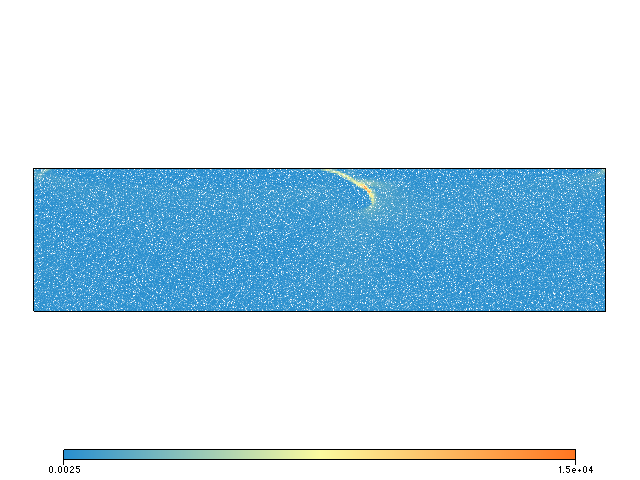

In [73]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm, strainRate_2ndInvariant))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField -velocityFieldIso))

#fig.append( glucifer.objects.Surface(mesh,ndflm, logScale=True))
fig.show()

In [74]:
fig.save_database('test.gldb')

'test.gldb'

Advection-diffusion System setup
-----

In [75]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

passiveadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [76]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

Analysis functions / routines
-----

Most of the metrics we want to calculate are either:

* extrema of some field / function
* integral of some field / function
* average value of some function (integral divide by area)

In addition, we also want to be able to determine these metrics over some restricted part of the domain, where the restriction may either be due some value of a field, a material type, or something more arbitrary.

Much of he challenge lies in defining these restriction functions in an efficient and robust way (i.e they don't break down as the model evolves)

For volume integrals, and extrema, we build a hierarchy of restriction functions, each borrowing from the previous, until we have divided the domain into a number of sub regions of interest. 

In general, averages are found afterwards by combining the integral and the area of the relavent subregion

In [78]:
###################
#Volume Restriction functions
###################

#Level 1. Global
globRestFn = fn.misc.constant(1.)

#Level 2. Rock - air:
rockRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
rockRestFn.data[:] = 0.
rockRestFn.data[np.where(materialVariable.data[:] != airIndex)] = 1.
rockRestFn *= globRestFn #Add next level up in heirarchy


#Level 3. lithosphere - mantle:
tempMM = fn.view.min_max(temperatureField)
tempMM.evaluate(mesh)
TMAX = tempMM.max_global()
mantleconditions = [ (                                  temperatureField < 0.9*TMAX, 1.),
                   (                                                   True , 0.) ]
lithRestFn = fn.branching.conditional(mantleconditions)
lithRestFn*=rockRestFn #Add next level up in heirarchy


#Level 4. lower plate - upper plate:


#This whole section simply builds a restriction Fn that separates the upper and lower plate 
#It's pretty cumbersome, and will need to advected, rebuilt
#can YOU think of a better way?


    
fthickness = 20e3/dp.LS #initialize tracking swarm at ~ mid lithosphere depth

if dp.sense == 'Right':
    introPoint = ndp.lRidge + fthickness #
else:
    introPoint = ndp.rRidge - fthickness #
nfault = 200
slabCoords =np.zeros((nfault, 2))

reducedRocM = ndp.roc  - fthickness
xlimslab = reducedRocM*math.cos(math.pi*(90. - dp.theta)/180)
slabCoords[:, 0] = np.linspace(introPoint, ndp.subzone + xlimslab, nfault) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(slabCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < ndp.subzone:
        slabCoords[index[0], 1] = 1. - fthickness #This bit for the plate 
        
    else:
        slabCoords[index[0], 1] = (1. - (fthickness) - (reducedRocM - ( math.sqrt((reducedRocM**2 - (xval-ndp.subzone)**2)))))
        
slabCoords = slabCoords[slabCoords[:,1] > (1. - ndp.maxDepth)] #kill any deeper than cutoff

slab_line  = marker2D.markerLine2D(mesh, velocityField, slabCoords[:, 0], slabCoords[:, 1], 1e9/dp.LS, 0.0, 0.0, crustIndex)
lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 )
lowerPlateRestFn.data[:] = 0.0

update_swarm_from_line(slab_line, lowerPlateRestFn )
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data != 0.)] += fthickness #assume instances of 0. are actually where no fault on proc
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data > 0*fthickness)] = 1.
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data <= 0.*fthickness)] = 0. 
lowerPlateRestFn *= lithRestFn #Add next level up in heirarchy

#Also see if we can stick the the Velocity and coords on to this swarm as well
tipVar = uw.swarm.SwarmVariable(slab_line.swarm, dataType='double', count=4)
tipVar.data[:,:2] = velocityField.evaluate(slab_line.swarm)
tipVar.data[:,2:] = xFn.evaluate(slab_line.swarm)
tipVar.data[:,3:] = yFn.evaluate(slab_line.swarm)


#Level 5. hinge of lower plate:

hinge60Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (60e3/dp.LS)),  (xFn > ndp.subzone - 60e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge60RestFn = fn.branching.conditional(hinge60Spatialconditions)
hinge60RestFn*=lowerPlateRestFn #Add next level up in heirarchy



hinge180Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (180e3/dp.LS)),  (xFn > ndp.subzone - 180e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge180RestFn = fn.branching.conditional(hinge180Spatialconditions)
hinge180RestFn*=lowerPlateRestFn #Add next level up in heirarchy


#Level 6. crust/interface in hinge of lower plate:

interfaceRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
interfaceRestFn.data[:] = 0.
interfaceRestFn.data[np.where(materialVariable.data[:] == crustIndex)] = 1.
interfaceRestFn *= hinge60RestFn #Add next level up in heirarchy


In [82]:
respltconditions = [ 
                    (                                  hinge60RestFn*2. > rockRestFn*1., 1.),
                    (                                  lowerPlateRestFn*3. > hinge60RestFn*2. , 3.),
                    (                                  lithRestFn*5. > lowerPlateRestFn*3. , 4.),
                   (                                                   True , 0.) ]

respltFn = fn.branching.conditional(respltconditions )

In [83]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm,respltFn))
#fig.show()
#fig.save_database('test_restrict.gldb')

In [84]:
###################
#Surface Restriction functions
###################

def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srRestFn = platenessFn(val = 0.1)

In [85]:
###################
#Setup any Functions to be integrated
###################

sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
vx = velocityField[0]
v2x = fn.math.dot(velocityField[0],velocityField[0])
sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))
dw = temperatureField*velocityField[1]
sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vd = 2.*viscosityMapFn1*sinner
dTdZ = temperatureField.fn_gradient[1]



In [86]:
###################
#Create integral, max/min templates 
###################

def volumeint(Fn = 1., rFn=globRestFn):
    return uw.utils.Integral( Fn*rFn,  mesh )

def surfint(Fn = 1., rFn=globRestFn, surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)

def maxMin(Fn = 1.):
    #maxMin(Fn = 1., rFn=globRestFn
    #vuFn = fn.view.min_max(Fn*rFn) #the restriction functions don't work with the view.min_max fn yet
    vuFn = fn.view.min_max(Fn)
    return vuFn
    
   
    

In [87]:
#Setup volume integrals on different sub regions

##Whole rock domain

_areaintRock = volumeint(rockRestFn)
_tempintRock = volumeint(temperatureField, rockRestFn)
_rmsintRock = volumeint(sqrtv2,rockRestFn)
_dwintRock = volumeint(dw,rockRestFn)
_vdintRock = volumeint(vd,rockRestFn)

##Lith 

_areaintLith  = volumeint(lithRestFn)
_tempintLith  = volumeint(temperatureField, lithRestFn)
_rmsintLith  = volumeint(sqrtv2,lithRestFn)
_dwintLith  = volumeint(dw,lithRestFn)
_vdintLith  = volumeint(vd,lithRestFn)

##Lower plate

_areaintLower  = volumeint(lowerPlateRestFn)
_tempintLower  = volumeint(temperatureField, lowerPlateRestFn)
_rmsintLower  = volumeint(sqrtv2,lowerPlateRestFn)
_dwintLower = volumeint(dw,lowerPlateRestFn)
_vdintLower  = volumeint(vd,lowerPlateRestFn)

##Hinge lower plate

_areaintHinge180  = volumeint(hinge180RestFn)
_vdintHinge180  = volumeint(vd,hinge180RestFn)

_areaintHinge60  = volumeint(hinge60RestFn)
_vdintHinge60  = volumeint(vd,hinge60RestFn)


##Interface

_areaintInterface  = volumeint(interfaceRestFn)
_vdintInterface = volumeint(vd,interfaceRestFn)

In [88]:
#Setup surface integrals

_surfLength = surfint()
_rmsSurf = surfint(v2x)
_nuTop = surfint(dTdZ)
_nuBottom = surfint(dTdZ, surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])
_plateness = surfint(srRestFn)

In [89]:
#Setup max min fns (at the moment, we can't pass restriction function to view.min_max, so we're limited to whole volume or surface extrema)

##Whole rock domain

#_maxMinVisc = maxMin(viscosityMapFn1)  #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVisc.evaluate(mesh)
#_maxMinStressInv = maxMin(2*viscosityMapFn1*strainRate_2ndInvariant) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinStress.evaluate(mesh)
#_maxMinVd = maxMin(vd) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVd.evaluate(mesh)


_maxMinVel = maxMin(velocityField) 
dummyFn = _maxMinVel.evaluate(mesh)

_maxMinSr = maxMin(strainRate_2ndInvariant) 
dummyFn = _maxMinSr.evaluate(mesh)


#Surface extrema
_maxMinVxSurf = maxMin(vx)
dummyFn = _maxMinVxSurf.evaluate(tWalls)


In [91]:
#Volume Ints
areaintRock = _areaintRock.evaluate()[0]
tempintRock = _tempintRock.evaluate()[0]
rmsintRock = _rmsintRock.evaluate()[0]
dwintRock = _dwintRock.evaluate()[0]
vdintRock = _vdintRock.evaluate()[0]
areaintLith = _areaintLith.evaluate()[0]
tempintLith = _tempintLith.evaluate()[0]
rmsintLith = _rmsintLith.evaluate()[0]
dwintLith = _dwintLith.evaluate()[0]
vdintLith = _vdintLith.evaluate()[0]
areaintLower = _areaintLower.evaluate()[0]
tempintLower = _tempintLower.evaluate()[0]
rmsintLower = _rmsintLower.evaluate()[0]
dwintLower = _dwintLower.evaluate()[0]
vdintLower = _vdintLower.evaluate()[0]
vdintHinge180 = _vdintHinge180.evaluate()[0]
areaintHinge180 = _areaintHinge180.evaluate()[0]
vdintHinge60 = _vdintHinge60.evaluate()[0]
areaintHinge60= _areaintHinge60.evaluate()[0]
vdintInterface = _vdintInterface.evaluate()[0]
areaintInterface= _areaintInterface.evaluate()[0]

#Surface Ints
surfLength = _surfLength.evaluate()[0]
rmsSurf = _rmsSurf.evaluate()[0]
nuTop = _nuTop.evaluate()[0]
nuBottom = _nuBottom.evaluate()[0]
plateness = _plateness.evaluate()[0]

#Max mins
maxVel = _maxMinVel.max_global()
minVel = _maxMinVel.min_global() 
maxSr = _maxMinSr.max_global()
minSr = _maxMinSr.min_global()
maxVxsurf = _maxMinVxSurf.max_global()
minVxsurf = _maxMinVxSurf.min_global()

In [94]:
print(areaintRock)
print(tempintRock)
print(rmsintRock)
print(dwintRock)
print(vdintRock)
print(areaintLith)
print(tempintLith )
print(rmsintLith)
print(dwintLith)
print(vdintLith)
print(areaintLower)
print(tempintLower)
print(rmsintLower) 
print(dwintLower)
print(vdintLower)
print(vdintHinge60)
print(vdintHinge180)
print(vdintInterface)

print(surfLength)
print(rmsSurf)
print(nuTop)
print(nuBottom)
print(plateness)


print(maxVel)
print(minVel)
print(maxSr)
print(minSr)
print(maxVxsurf)
print(minVxsurf)

4.0
3.81536525607
319.632506792
4.96110874389
8736646.2572
0.372653537326
0.193605546076
57.0290374809
-3.87393889896
7178414.21978
0.243991427951
0.125793256971
37.7031953121
-3.54320713066
2247543.34362
1825432.87235
1856717.54192
309909.810183
4.0
83082.0820609
-71.2699790546
0.0
3.109375
406.236316647
0.0
14720.7072563
0.00379426289541
186.66599188
-150.691730065


In [96]:
print(vdintHinge60/vdintHinge180)
#print(vdintInterface)

print(vdintHinge60/vdintInterface)
#print(vdintInterface)

0.983150549903
5.8902068033


Viz.
-----

In [234]:
#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn1.evaluate(gSwarm)

In [235]:
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Mesh(mesh))
    figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    #figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
    figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,viscMinVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,fnViscMin))
    #figDb.append( glucifer.objects.Points(gSwarm,viscosityMapFn1, logScale=True))
    figDb.append( glucifer.objects.Points(gSwarm, strainRate_2ndInvariant))
    figDb.append( glucifer.objects.Points(gSwarm,temperatureField))
    
    
    figRestrict= glucifer.Figure()
    figRestrict.append( glucifer.objects.Points(gSwarm,respltFn))
    figRestrict.append( glucifer.objects.Points(slab_line.swarm, colours="Black Black", pointSize=2.0, colourBar=False) )

elif figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    store = glucifer.Store(fullpath + 'subduction.gldb')

    figTemp = glucifer.Figure(store,figsize=(300*np.round(aspectRatio,2),300))
    figTemp.append( glucifer.objects.Points(gSwarm,temperatureField))

    figVisc= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(gSwarm,viscosityMapFn1, logScale=True, valueRange =[1e-3,1e5]))

    #figMech= glucifer.Figure(store, figsize=(300*np.round(aspectRatio,2),300))
    #figMech.append( glucifer.objects.Points(gSwarm,fnViscMin))

**Miscellania**

In [236]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [103]:
##############
#These functions handle checkpointing
##############


#Subzone = ndp.subzone


def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        f_o.write((28*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    
    #Save the parameters
    dict_list = [dp, sf, ndp, md] #if any of the dictionaries have changed, this list needs to be rebuilt
    save_pickles(dict_list, dict_names, path)
    

In [104]:
##############
#These functions handle checkpointing
##############

def getnearpos(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx 

def plate_info(srfilename, minx, maxx,  searchdx, oldszloc = 0.0):
    """
    Use the surface strain rate field to find the location of the subduction zone in 2d
    
    """
    if type(srfilename) == str: #read surface strain rate points from file
        sr = np.load(srfilename)
    else:
        sr =  srfilename        #read surface strain rates directly from array
    xs = np.linspace(minx,maxx,sr.shape[0] )
    #infs at the ends of the SR data...replace with adjacent values
    sr[0] = sr[1] 
    sr[-1] = sr[2]
    #Normalize
    srx = (sr- sr.mean()) /(sr.max() - sr.min())
    #reduce the search domain, to near the previous PB location
    lx, rx = getnearpos(xs, oldszloc - searchdx),  getnearpos(xs, oldszloc + searchdx)
    red_xs, red_sr = xs[lx:rx], srx[lx:rx]
    #return the minima
    newszLoc = red_xs[np.argmin(red_sr)]
    return newszLoc 

In [105]:
# initialise timer for computation
start = time.clock()


In [106]:
#max_vx_surf(velocityField, mesh)

Main simulation loop
-----


In [190]:
#while step < 6:
while realtime < 0.002:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    passiveadvector.integrate(dt)
    slab_line.advection(dt)
    for f in faults:
        f.advection(dt)
        
    
 
    
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Rebuild the restriction functions where necessary
        ###############
        lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 )
        lowerPlateRestFn.data[:] = 0.0
        update_swarm_from_line(slab_line, lowerPlateRestFn )
        lowerPlateRestFn.data[np.where(lowerPlateRestFn.data >= -1.*fthickness)] = 1.
        lowerPlateRestFn.data[np.where(lowerPlateRestFn.data < -1.*fthickness)] = 0. 
        lowerPlateRestFn *= lithRestFn #Add next level up in hierarchy
        
        ###############
        #Metrics
        ###############
        areaintRock = _areaintRock.evaluate()[0] #trivial except when using sticky air
        tempintRock = _tempintRock.evaluate()[0]
        rmsintRock = _rmsintRock.evaluate()[0]
        dwintRock = _dwintRock.evaluate()[0]
        vdintRock = _vdintRock.evaluate()[0]
        areaintLith = _areaintLith.evaluate()[0]
        tempintLith = _tempintLith.evaluate()[0]
        rmsintLith = _rmsintLith.evaluate()[0]
        dwintLith = _dwintLith.evaluate()[0]
        vdintLith = _vdintLith.evaluate()[0]
        areaintLower = _areaintLower.evaluate()[0]
        tempintLower = _tempintLower.evaluate()[0]
        rmsintLower = _rmsintLower.evaluate()[0]
        dwintLower = _dwintLower.evaluate()[0]
        vdintLower = _vdintLower.evaluate()[0]
        vdintHinge180 = _vdintHinge180.evaluate()[0]
        areaintHinge180 = _areaintHinge180.evaluate()[0]
        vdintHinge60 = _vdintHinge60.evaluate()[0]
        areaintHinge60= _areaintHinge60.evaluate()[0]
        vdintInterface = _vdintInterface.evaluate()[0]
        areaintInterface= _areaintInterface.evaluate()[0]
        #Surface integrals
        rmsSurf = _rmsSurf.evaluate()[0]
        nuTop = _nuTop.evaluate()[0]
        nuBottom = _nuBottom.evaluate()[0]
        plateness = _plateness.evaluate()[0]
        #extrema
        maxVel = _maxMinVel.max_global()
        minVel = _maxMinVel.min_global() 
        maxSr = _maxMinSr.max_global()
        minSr = _maxMinSr.min_global()
        maxVxsurf = _maxMinVxSurf.max_global()
        minVxsurf = _maxMinVxSurf.min_global()
        # output to summary text file
        if uw.rank()==0:
            f_o.write((22*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()   
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        if figures == 'gldb':
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
            
            #Temp figure
            fnamedb = "restrictFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figRestrict.save_database(fullpath)
        elif figures == 'store':      
            fullpath = os.path.join(outputPath + "gldbs/")
            store.step = step
            #Save figures to store
            figVisc.save( fullpath + "Visc" + str(step).zfill(4))
            #figMech.save( fullPath + "Mech" + str(step).zfill(4))
            figTemp.save( fullpath + "Temp"    + str(step).zfill(4))
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
            
        #Save the slab_lineand tipswarm coords 
        fnametemp1 = "midSwarm" + "_" + str(step)
        fullpath1 = os.path.join(outputPath + "files/" + fnametemp1)
        slab_line.swarm.save(fullpath1)
        #tipVar.data[:,:2] = velocityField.evaluate(tipSwarm)
        #tipVar.data[:,2:] = xFn.evaluate(tipSwarm)
        #tipVar.data[:,3:] = yFn.evaluate(tipSwarm)
        #comm.barrier()
        #fnametemp2 = "tipSwarm" + "_" + str(step)
        #fullpath2 = os.path.join(outputPath + "files/" + fnametemp2)
        #tipVar.save('fullpath2')
            
    ################
    #Update the subduction zone / plate information
    ################ 
    
    comm.barrier()
    if (step % files_output == 0):
        
        if uw.rank() == 0:
            fnametemp = "norm_surface_sr" + "_" + str(step) + ".npy"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            ndp.subzone = plate_info(fullpath, MINX, MAXX,  800e3/dp.LS, oldszloc = ndp.subzone)
            
        else:
            ndp.subzone = None
        
        comm.barrier()    
        #send out the updated info for sz location
        
        ndp.subzone = comm.bcast(ndp.subzone, root=0)

        #Has the polarity reversed?

        if dp.sense == 'right':
            tempop = operator.lt
            szoffet *= -1
        else:
            tempop = operator.gt
            
        #Update the relevant parts of the material graph
        #Remove and rebuild edges related to crust
        DG.remove_edges_from([(mantleIndex,crustIndex)])
        DG.add_edges_from([(mantleIndex,crustIndex)])
        DG.remove_edges_from([(harzIndex,crustIndex)])
        DG.add_edges_from([(harzIndex,crustIndex)])

        #... to crust
        DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, 0.5)
        DG.add_transition((mantleIndex,crustIndex), xFn, tempop , ndp.subzone) #No crust on the upper plate
        DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, 0.2)

        DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
        DG.add_transition((harzIndex,crustIndex), xFn, tempop, ndp.subzone) #This one sets no crust on the upper plate
        DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)
        
        comm.barrier()
                   
    
    ################
    #Particle update
    ###############    
    #ageVariable.data[:] += dt #increment the ages (is this efficient?)
    ageDT += dt
    
    if step % swarm_update == 0:
        #Increment age stuff. 
        ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable + ageDT ),  #add ageDThere
                  (True, 0.) ]
        ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)        
        ageDT = 0. #reset the age incrementer
        
        #Apply any materialVariable changes
        for i in range(2): #go through twice
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
        
        #Also update any information related to faults:
        update_swarm_from_faults(faults[1:], proximityVariable, directorVector, signedDistanceVariable)
        mask_materials(faults[1], airIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

        update_swarm_from_faults(faults[0:-1], proximityVariable, directorVector, signedDistanceVariable)
        mask_materials(faults[0], crustIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)
        
        proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0.
            
    

    
f_o.close()
print 'step =',step

KeyboardInterrupt: 

In [98]:
#vxTi = velocityField[0].evaluate(surface_nodes)
#vxIso = velocityFieldIso[0].evaluate(surface_nodes)
#%pylab inline
#fig, axes = plt.subplots(figsize=(16,4))
#axes.plot(vxTi)
#axes.plot(vxIso)


#fig, axes = plt.subplots(figsize=(16,4))
#axes.plot(vxTi)
#axes.plot(surface_xs, vxTi - vxIso)
#fig.savefig('Ti_minus_Iso.png')
#plt.title('surface velocity residual - T. Iso minus Iso. weak zone')
